# Fast AI 1 - Building an Image Classifier - Dog Breeds
This model is based of the fast ai course's first lesson:

https://course.fast.ai/videos/?lesson=1


In [1]:
# Download the FastAi software (Required as the notebook was run on Google Colab)
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [2]:
# Link Google Drive to read and write files
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Jupyter magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# Load the key packages

# Fast AI
from fastai.vision import *
from fastai.metrics import error_rate

# Other key modules
from pathlib import Path
import numpy as np

In [0]:
# Batch Size for model training
BS = 64

## Stage 1: Understanding the data

In [0]:
# Path to the files in Google Drive
path = Path('/content/gdrive/My Drive/data/dog-breed-identification')

In [7]:
path.ls()

[PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/labels.csv'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train.zip'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/models')]

Notes:
The current structure of the system is all the images are in the train folder with their respective labels in the labels csv file

In [0]:
path_img = path/'train'

We can see (below) the images are listed for all classes in the same folder

In [9]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train/41f8aa08a201a2c2fa5a60ced8eadf34.jpg'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train/57926baaefa51fe0de7e2641edb0d644.jpg'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train/4a844fbe8e45618962aa8440cc881035.jpg'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train/5cf7a6e59deee02173bb24459d197e06.jpg'),
 PosixPath('/content/gdrive/My Drive/data/dog-breed-identification/train/f750daa88a8129fd8af9e6b686698147.jpg')]

In [10]:
df = pd.read_csv(path/'labels.csv')
df['id'] = df['id'] + ".jpg"
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07.jpg,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97.jpg,dingo
2,001cdf01b096e06d78e9e5112d419397.jpg,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d.jpg,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62.jpg,golden_retriever


In [0]:
np.random.seed(11)
data = ImageDataBunch.from_df(path,df=df, folder="train", ds_tfms=get_transforms(), size=299, bs=BS//2, valid_pct=0.2).normalize(imagenet_stats)

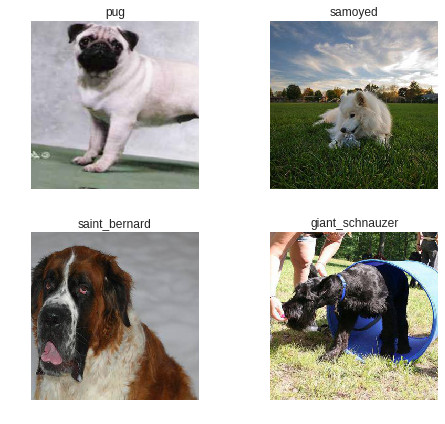

In [20]:
# View some example data
data.show_batch(rows=2, figsize=(7,6))

In [14]:
# Check the classes the model will be training against
print(data.classes)
len(data.classes)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

120

## Training: Setting up the model

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy])

In [30]:
# View the model architecture
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [31]:
# Start training the model
learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,accuracy,time
0,1.939164,0.925974,0.796477,40:09
1,0.931113,0.538858,0.831213,05:01
2,0.785900,0.562603,0.827789,04:57
3,0.807305,0.477599,0.849315,04:56
4,0.636077,0.464847,0.857632,04:58
5,0.519853,0.434783,0.868885,04:54
6,0.486547,0.430979,0.876223,04:56
7,0.354127,0.398572,0.879648,04:59
8,0.283275,0.400901,0.881115,04:59
9,0.232826,0.378274,0.886008,04:58


In [0]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


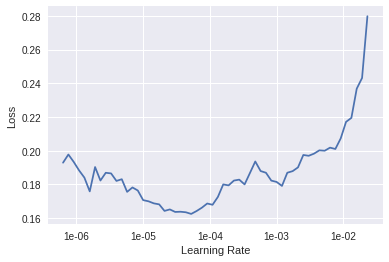

In [33]:
# Find an optimial learning rate
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.170239,0.371044,0.890411,06:22
1,0.186394,0.377858,0.884051,06:17
2,0.174264,0.385089,0.882583,06:18
3,0.183498,0.379091,0.885029,06:15


In [0]:
learn.save('stage-2')

Evaluate the model

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

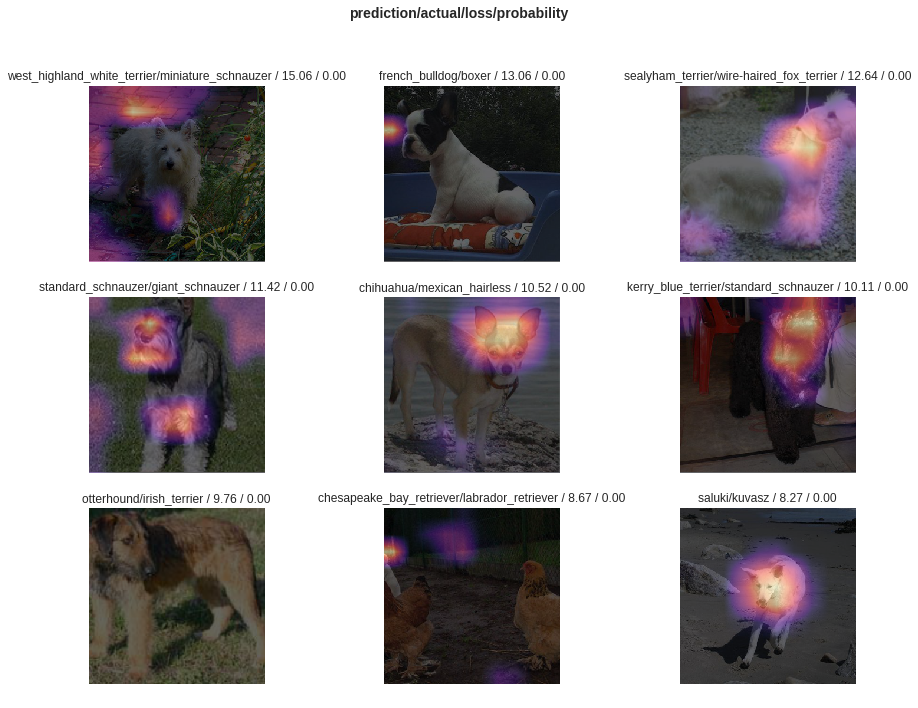

In [38]:
interp.plot_top_losses(9, figsize=(15,11))

In [39]:
interp.most_confused(min_val=4)

[('silky_terrier', 'australian_terrier', 8),
 ('miniature_poodle', 'toy_poodle', 7),
 ('walker_hound', 'english_foxhound', 7),
 ('collie', 'shetland_sheepdog', 5),
 ('lhasa', 'shih-tzu', 5),
 ('malamute', 'siberian_husky', 5),
 ('american_staffordshire_terrier', 'staffordshire_bullterrier', 4),
 ('eskimo_dog', 'siberian_husky', 4),
 ('norwich_terrier', 'norfolk_terrier', 4)]

In [0]:
# Save the model to google drive
learn.load('stage-2')
learn.save('/content/gdrive/My Drive/data/dog_breed_model_identification')

## Stage 2 - Predict Individual Images

In [0]:

img = open_image('/content/gdrive/My Drive/data/lr.jpg')

value = np.where(np.array(learn.predict(img)[2]) == np.max(np.array(learn.predict(img)[2])))
np.array(data.classes)[value]



array(['labrador_retriever'], dtype='<U30')

In [0]:
print(np.max(np.array(learn.predict(img)[2])))

0.9909479


In [0]:
# Example of making a prediction through loading a model

In [0]:
model = cnn_learner(data, models.resnet50, metrics=error_rate)
model = model.load('/content/gdrive/My Drive/data/dog_breed_model_identification.pth')

In [0]:
img = open_image('/content/gdrive/My Drive/data/sm2.jpg')

value = np.where(np.array(model.predict(img)[2]) == np.max(np.array(model.predict(img)[2])))
print(np.array(data.classes)[value])
print(np.max(np.array(model.predict(img)[2])))

['samoyed']
0.9968376
